# TTV

This module incorporates various capabilities relating to transit timing variations.

- Hadden2019
    1. PR_min_max_allin1
    1. PR_min_max (*duplicates PR_min_max_allin1*)
        - mu
        - alpha0
        - A
        - ftilde
        - gtilde
        - Ham_eqn19
        - J
        - P
        - Jstar
        - max_Ham_eqn19
        - Ham_eqn19_Jsolver
        - PR_P
- REBOUND_TTV
    1. tns_tts_2planet (*superseded by tns_tts_nplanet*)
    1. tns_tts_3planet (*superseded by tns_tts_nplanet*)
    1. tns_tts_nplanet (*superseded by tns_tts_nplanet_l*)
    1. tns_tts_nplanet_l
    1. tns_tts_nplanet_l_xLOS_withdur
- TTV_fitting
    1. TTV_leastsquares
    1. samples_SPOCK
    1. samples_Zstable
    1. stable_physical_LS_fit
    1. chisq_TTV
    1. chisq_tt
    1. output_tts

## Hadden2019

This package implements the analytical framework of Hadden 2019. Likely most of this would be better found using Hadden's publicly available package `celmech` these days.

This was used in the analytical treatment in Bailey, Gilbert, & Fabrycky 2022. To quote:

"In brief, we first calculate the conserved quantity $J^*$ for a given system (from H19 Equations 9, 20, and the relation $J^*=J-kP$) and then find the unstable fixed point at $\theta=0$ by finding the value of the conjugate momentum $J$ that maximizes $\mathcal{H}$ and therefore determines the energy of the separatrix ($E_{sep}$). The maximum width is calculated by solving $\mathcal{H}(J,\pi/2;J^*)=E_{sep}$ for $J$. The two $J$ values can be converted back to orbital elements using provided relations (H19 Equation 21), giving a minimum and maximum period ratio for the resonance."

In [1]:
import Hadden2019

import numpy as np

In [2]:
#the main function in this package is PR_min_max_allin1
#PR_min_max does the exact same thing but uses the other individually defined functions instead
#one or the other may be easier to follow, but here I will demonstrate just the PR_min_max_allin1

#inputs are the system properties: j,k,Mstar,m1,m2,P1,P2,e1,e2,pomega1,pomega2
#j and k identify the resonance j:j-k

#outputs are the minimum period ratio and maximum period ratio of the resonance
#these are the boundaries of the resonance in period ratio

#create our sample system near 5:3
Mstar = 322776
e1 = .08
e2 = .03
pomega1 = 0
pomega2 = np.pi
P1 = 30
P2 = 5/3*P1*1.0001
m1 = 10
m2 = 10

PRmin,PRmax = Hadden2019.PR_min_max_allin1(5,2,Mstar,m1,m2,P1,P2,e1,e2,pomega1,pomega2)

print('resonant between',PRmin,'and',PRmax)

resonant between 1.6579721761233375 and 1.675361157209996


Text(0, 0.5, 'e1+e2')

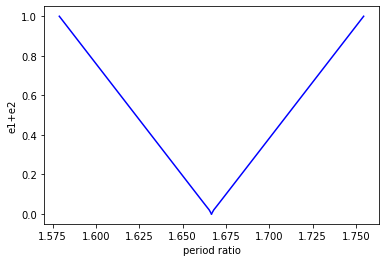

In [3]:
#what does the 5:3 resonance look like in e1+e2 vs PR?
#assuming equally split eccs and anti-aligned pericenters

%matplotlib inline
import matplotlib.pyplot as plt

eccsums = np.linspace(0,1)

PRmins = np.empty(len(eccsums))
PRmaxs = np.empty(len(eccsums))
for i,esum in enumerate(eccsums):
    PRmins[i],PRmaxs[i] = Hadden2019.PR_min_max_allin1(5,2,Mstar,m1,m2,P1,P2,.5*esum,.5*esum,pomega1,pomega2)

plt.plot(PRmins,eccsums,'b')
plt.plot(PRmaxs,eccsums,'b')
plt.xlabel('period ratio')
plt.ylabel('e1+e2')

## REBOUND_TTV

This package uses `REBOUND` to calculate transit numbers and times for simulated systems. For the most part, this only exists to be used in conjuction with fitting TTVs, but could be used on its own for various reasons, like to predict TTVs for a proposed system.

In [4]:
import REBOUND_TTV

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u

Text(0, 0.5, 'O-C')

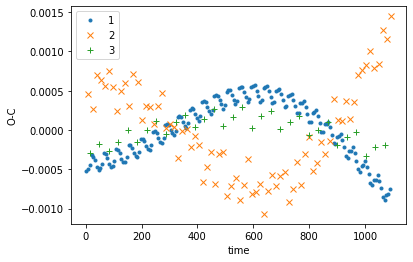

In [5]:
#tns_tts_nplanet_l
#this is the most flexible and updated of the functions
#allows for any number of planets, integrates both forwards and backwards for more accuracy
#uses the -z axis as the line of sight (note that in rebound the +x is the reference direction)

#input array [N+1] of masses
#this is assumed to be solar masses but I think as long as they're all the same it won't affect the results
masses = [1,1e-5,1e-5,1e-5]

#input array [N,6] of orbits
#orbital elements are P, e, inc, Omega, omega, l (mean longitude) in units of days and rads
#this is a random sample system I had on hand
orbits = np.array([[6.28,.1,np.pi/2,0.0,0.25,0.0],
         [14.63,0,np.pi/2,0.0,-.5*np.pi,.5*np.pi],
         [34.09,.05,np.pi/2,0.0,0.0,0]])

#input start and end of desired integration and reference time for orbital elements (between start and end)
t0 = 0
tref = 500 #keep in mind this tref should correspond with the orbital elements given (esp mean long)
tmax = 1094

#the transit numbers and transit times are output in a single 1D array each
#the third output array, planet flags, can be used to identify the numbers and times for a given planet
#planet flags are integers starting at 1
pflags,tns,tts = REBOUND_TTV.tns_tts_nplanet_l(masses,orbits,t0,tmax,tref)

tns1 = tns[pflags==1]
tts1 = tts[pflags==1]

#to get TTVs, you have to get the linear ephemeris and subtract it
P1,T1 = np.polyfit(tns1,tts1,1)
tts1_linear = P1*tns1+T1
TTVs1 = tts1 - tts1_linear

#repeat for the other 2 planets
tns2 = tns[pflags==2]
tts2 = tts[pflags==2]
P2,T2 = np.polyfit(tns2,tts2,1)
tts2_linear = P2*tns2+T2
TTVs2 = tts2 - tts2_linear

tns3 = tns[pflags==3]
tts3 = tts[pflags==3]
P3,T3 = np.polyfit(tns3,tts3,1)
tts3_linear = P3*tns3+T3
TTVs3 = tts3 - tts3_linear

#plot the TTVs
plt.plot(tts1,TTVs1,'.',label='1')
plt.plot(tts2,TTVs2,'x',label='2')
plt.plot(tts3,TTVs3,'+',label='3')
plt.legend()
plt.xlabel('time')
plt.ylabel('O-C')

Text(0, 0.5, 'O-C')

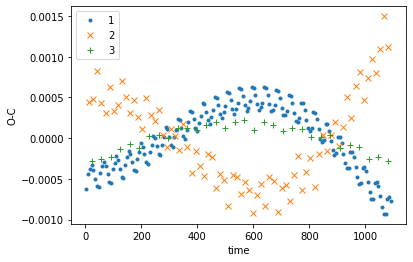

In [6]:
#tns_tts_nplanet_l_xLOS_withdur
#this function is the same as the tns_tts_nplanet_l but uses the +x axis as the line of sight
#also returns a transit duration output

#takes an additional radius array input (in AU)
radii = [(1*u.Rsun).to_value(u.AU),(2*u.Rearth).to_value(u.AU),(2*u.Rearth).to_value(u.AU),(2*u.Rearth).to_value(u.AU)]

pflags,tns,tts,tds = REBOUND_TTV.tns_tts_nplanet_l_xLOS_withdur(masses,radii,orbits,t0,tmax,tref)

tns1 = tns[pflags==1]
tts1 = tts[pflags==1]
P1,T1 = np.polyfit(tns1,tts1,1)
tts1_linear = P1*tns1+T1
TTVs1 = tts1 - tts1_linear

tns2 = tns[pflags==2]
tts2 = tts[pflags==2]
P2,T2 = np.polyfit(tns2,tts2,1)
tts2_linear = P2*tns2+T2
TTVs2 = tts2 - tts2_linear

tns3 = tns[pflags==3]
tts3 = tts[pflags==3]
P3,T3 = np.polyfit(tns3,tts3,1)
tts3_linear = P3*tns3+T3
TTVs3 = tts3 - tts3_linear

#plot the TTVs
plt.plot(tts1,TTVs1,'.',label='1')
plt.plot(tts2,TTVs2,'x',label='2')
plt.plot(tts3,TTVs3,'+',label='3')
plt.legend()
plt.xlabel('time')
plt.ylabel('O-C')

avg transit durations: 0.907057218649932 1.0000106275811766 0.9511967280501509


Text(0, 0.5, 'transit duration (minus average)')

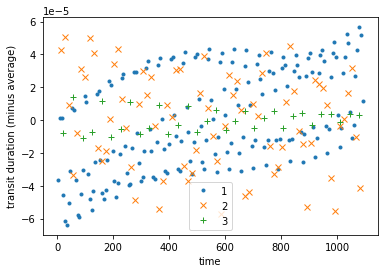

In [7]:
#this was a function I never really used and was probably still working on
#so I don't know if the durations really work (or what the units are? days?)
#but this is what you get

tds1 = tds[pflags==1]
tds2 = tds[pflags==2]
tds3 = tds[pflags==3]

print('avg transit durations:',np.mean(tds1),np.mean(tds2),np.mean(tds3))

#plotting the duration minus the mean duration for scale and comparison between all the planets
plt.plot(tts1,tds1-np.mean(tds1),'.',label=1)
plt.plot(tts2,tds2-np.mean(tds2),'x',label=2)
plt.plot(tts3,tds3-np.mean(tds3),'+',label=3)
plt.legend()
plt.xlabel('time')
plt.ylabel('transit duration (minus average)')

## TTV_fitting

This package contains a few functions used for fitting TTVs. However, mostly for TTV fitting I actually used the `emcee` package and wrote individual functions for the prior, likelihood, probability, etc. That code is outside the scope of this writeup but was done following tutorials given by __[that package's documentation](https://emcee.readthedocs.io/en/stable/)__. (I have included in a subfolder with two example code files of fitting done from transit times for Kepler-18 from Greg Gilbert, one that run's the MCMC sampler (REBOUND_MCMC2_median.py) and one that loads and displays the outcome (REBOUND_emcee2_median_load.py). The data from Greg is also included in .npz format as well as a set of MCMC chains from running this code previously. I haven't reviewed that code for accuracy or clarity, but it may be helpful in understanding the process of using `emcee` to fit TTVs.)

In [8]:
import TTV_fitting

import REBOUND_TTV
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
#TTV_leastsquares
#this package uses a least squares fitting routine (from scipy) to fit parameters to TTVs

#tt_data is the input of known data that the function will try to match
#input as a 2D array of [transit numbers,transit times,planet flags,transit times errors/stds]

#the next inputs are the parameters that will be fit (initial guess):
#masses ([N+1] array)
#and orbits ([N,6] array with (P,e,inc,Om,om,l) for each planet in days/rads)
#note that inc and Om are not fit but are used as input

#lastly the min/max time and reference time are input
#and the parameter bounds ([2,N*5] array with minimum and maximum allowed values)

#let's use our data from the previous example (rerun here in case you're starting here)
masses = [1,1e-5,1e-5,1e-5]
orbits = np.array([[6.28,.1,np.pi/2,0.0,0.25,0.0],
         [14.63,0,np.pi/2,0.0,-.5*np.pi,.5*np.pi],
         [34.09,.05,np.pi/2,0.0,0.0,0]])

t0 = 0
tref = 500 #keep in mind this tref should correspond with the orbital elements given (esp mean long)
tmax = 1094
pflags,tns,tts = REBOUND_TTV.tns_tts_nplanet_l(masses,orbits,t0,tmax,tref)

#since we don't have stds for the tts, I'll just give them 1% errors
tts_std = .01*tts

In [10]:
#pretend we don't know the true values for planets but have an estimate (e.g. from a mass-radius relation)
#star's mass is fixed so we'll assume that's known here
guess_masses = [1,1.2e-5,.8e-5,1.5e-5]
#initial guess for orbits: P and l should be estimated easily from transit data
#ecc vectors guess something arbitrary (here I'll go aligned pericenters and .05 ecc)
#use fixed 90 deg incs and 0 deg Omegas
guess_orbits = np.array([[6.3,.05,np.pi/2,0.0,np.pi,0.0],
         [14.6,.05,np.pi/2,0.0,np.pi,.5*np.pi],
         [34.1,.05,np.pi/2,0.0,np.pi,0]])

#for bounds, use physical reasoning
#order is m1,P1,l1,esinom1,ecosom1,m2,P2,l2,esinom2,ecosom2,m3,P3,l3,esinom3,ecosom3
minmass = 0
maxmass = .012 #this is roughly the brown dwarf cutoff
minl = -np.pi
maxl = np.pi
minevec = -1
maxevec = 1
bounds = [[minmass,3,minl,minevec,minevec,minmass,10.5,minl,minevec,minevec,minmass,24.4,minl,minevec,minevec],
         [maxmass,10.4,maxl,maxevec,maxevec,maxmass,24.3,maxl,maxevec,maxevec,maxmass,68,maxl,maxevec,maxevec]]

In [11]:
#this may take a while
fit,cov = TTV_fitting.TTV_leastsquares([tns,tts,pflags,tts_std],guess_masses,guess_orbits,t0,tmax,tref,bounds)

m1: 2.8948744049248553e-06 +/- 0.000160218927869463 consistent with true value (1e-05)
P1: 6.278189386186439 +/- 0.0005537925920017376 NOT consistent with true value (6.28)
l1: -0.07479457557017744 +/- 0.0003796523331477039 NOT consistent with true value (0)
esin1: -0.09406710253696766 +/- 0.0012246733101679706 NOT consistent with true value (0.024740395925452296)
ecos1: 0.015391536503108883 +/- 0.000714663814827387 NOT consistent with true value (0.09689124217106448)
m2: 0.00012725051902495531 +/- 0.00010819834405382224 NOT consistent with true value (1e-05)
P2: 14.628144569938952 +/- 0.002520850556113823 consistent with true value (14.63)
l2: 1.5308217344514465 +/- 0.002552843192478161 NOT consistent with true value (1.5707963267948966)
esin2: -0.08019553416679932 +/- 0.002364386324223408 NOT consistent with true value (-0.05)
ecos2: -0.021231868853066386 +/- 0.001758641679557366 NOT consistent with true value (3.061616997868383e-18)
m3: 8.604070773014555e-05 +/- 0.000125740800109028

Text(0, 0.5, 'O-C')

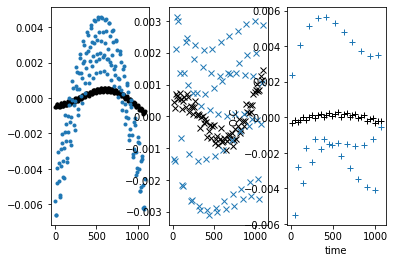

In [12]:
#let's see how we did
params = ['m1','P1','l1','esin1','ecos1',
         'm2','P2','l2','esin2','ecos2',
         'm3','P3','l3','esin3','ecos3']

truths = [1e-5,6.28,0,.1*np.sin(.25),.1*np.cos(.25),
         1e-5,14.63,.5*np.pi,.05*np.sin(-.5*np.pi),.05*np.cos(-.5*np.pi),
         1e-5,34.09,0,.2*np.sin(0),.2*np.cos(0)]

for p,f,c,t in zip(params,fit,np.sqrt(np.diag(cov)),truths):
    if f+c>=t and f-c<=t:
        outcome = 'consistent with true value (' + str(t) +')'
    else:
        outcome = 'NOT consistent with true value (' + str(t) +')'
    print(p+':',f,'+/-',c,outcome)

fit_masses = [1,fit[0],fit[5],fit[10]]
fit_orbits = np.array([[fit[1],np.sqrt(fit[3]**2+fit[4]**2),np.pi/2,0.0,np.arctan2(fit[3],fit[4]),fit[2]],
         [fit[6],np.sqrt(fit[8]**2+fit[9]**2),np.pi/2,0.0,np.arctan2(fit[8],fit[9]),fit[7]],
         [fit[11],np.sqrt(fit[13]**2+fit[14]**2),np.pi/2,0.0,np.arctan2(fit[13],fit[14]),fit[12]]])
pflags_fit,tns_fit,tts_fit = REBOUND_TTV.tns_tts_nplanet_l(fit_masses,fit_orbits,t0,tmax,tref)

tns_fit1 = tns_fit[pflags_fit==1]
tts_fit1 = tts_fit[pflags_fit==1]
P1,T1 = np.polyfit(tns_fit1,tts_fit1,1)
tts_fit1_linear = P1*tns_fit1+T1
TTVs_fit1 = tts_fit1 - tts_fit1_linear

tns_fit2 = tns_fit[pflags_fit==2]
tts_fit2 = tts_fit[pflags_fit==2]
P2,T2 = np.polyfit(tns_fit2,tts_fit2,1)
tts_fit2_linear = P2*tns_fit2+T2
TTVs_fit2 = tts_fit2 - tts_fit2_linear

tns_fit3 = tns_fit[pflags_fit==3]
tts_fit3 = tts_fit[pflags_fit==3]
P3,T3 = np.polyfit(tns_fit3,tts_fit3,1)
tts_fit3_linear = P3*tns_fit3+T3
TTVs_fit3 = tts_fit3 - tts_fit3_linear
                       
tns1 = tns[pflags==1]
tts1 = tts[pflags==1]
P1,T1 = np.polyfit(tns1,tts1,1)
tts1_linear = P1*tns1+T1
TTVs1 = tts1 - tts1_linear

tns2 = tns[pflags==2]
tts2 = tts[pflags==2]
P2,T2 = np.polyfit(tns2,tts2,1)
tts2_linear = P2*tns2+T2
TTVs2 = tts2 - tts2_linear

tns3 = tns[pflags==3]
tts3 = tts[pflags==3]
P3,T3 = np.polyfit(tns3,tts3,1)
tts3_linear = P3*tns3+T3
TTVs3 = tts3 - tts3_linear

#plot the TTVs_fit and input TTVs
plt.subplot(131)
plt.plot(tts1,TTVs1,'k.')
plt.plot(tts_fit1,TTVs_fit1,'.')
plt.subplot(132)
plt.plot(tts2,TTVs2,'kx')
plt.plot(tts_fit2,TTVs_fit2,'x')
plt.subplot(133)
plt.plot(tts3,TTVs3,'k+')
plt.plot(tts_fit3,TTVs_fit3,'+')
plt.xlabel('time')
plt.ylabel('O-C')

In [13]:
#not a very good job I'm afraid...part of why this sort of problem needs the MCMC treatment!

In [14]:
#samples_make_physical
#this function takes a fit and covariance matrix and finds a desired number of samples that are physical
#that is, removes negative masses or e>1
#if no number of samples is specified, will return 10^5

physical_samples = TTV_fitting.samples_make_physical(fit,cov)

intially 40816 of 100000 physical


m1: 0.00011609210219083469 +/- 9.853556389347693e-05 NOT consistent with true value (1e-05)
P1: 6.278142575632652 +/- 0.00045668422614956165 NOT consistent with true value (6.28)
l1: -0.07474533901293343 +/- 0.00035280447917090013 NOT consistent with true value (0)
esin1: -0.09425841110270537 +/- 0.0012099868645972078 NOT consistent with true value (0.024740395925452296)
ecos1: 0.015446724714280408 +/- 0.0006806868099104675 NOT consistent with true value (0.09689124217106448)
m2: 0.00014306797592900902 +/- 8.92647417210776e-05 NOT consistent with true value (1e-05)
P2: 14.627749767657066 +/- 0.002185020906167392 NOT consistent with true value (14.63)
l2: 1.529834150884784 +/- 0.0023379057787102264 NOT consistent with true value (1.5707963267948966)
esin2: -0.07978709094456946 +/- 0.002283212597445641 NOT consistent with true value (-0.05)
ecos2: -0.021349939116852054 +/- 0.001726273079331323 NOT consistent with true value (3.061616997868383e-18)
m3: 0.00015639030586248433 +/- 9.4698827

Text(0, 0.5, 'O-C')

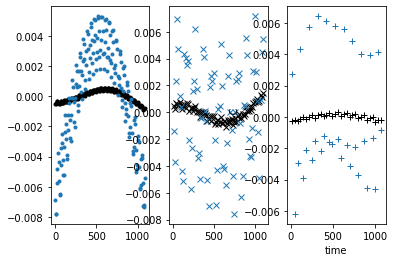

In [15]:
#can use these physical samples to come up with values/errors
#still not much better though
for i,p in enumerate(params):
    t = truths[i]
    psamp = physical_samples[:,i]
    f = np.median(psamp)
    c = np.std(psamp)
    if f+c>=t and f-c<=t:
        outcome = 'consistent with true value (' + str(t) +')'
    else:
        outcome = 'NOT consistent with true value (' + str(t) +')'
    print(p+':',f,'+/-',c,outcome)
    
fitphys = np.median(physical_samples,axis=0)

fitphys_masses = [1,fitphys[0],fitphys[5],fitphys[10]]
fitphys_orbits = np.array([[fitphys[1],np.sqrt(fitphys[3]**2+fitphys[4]**2),np.pi/2,0.0,np.arctan2(fitphys[3],fitphys[4]),fitphys[2]],
         [fitphys[6],np.sqrt(fitphys[8]**2+fitphys[9]**2),np.pi/2,0.0,np.arctan2(fitphys[8],fitphys[9]),fitphys[7]],
         [fitphys[11],np.sqrt(fitphys[13]**2+fitphys[14]**2),np.pi/2,0.0,np.arctan2(fitphys[13],fitphys[14]),fitphys[12]]])
pflags_fitphys,tns_fitphys,tts_fitphys = REBOUND_TTV.tns_tts_nplanet_l(fitphys_masses,fitphys_orbits,t0,tmax,tref)

tns_fitphys1 = tns_fitphys[pflags_fitphys==1]
tts_fitphys1 = tts_fitphys[pflags_fitphys==1]
P1,T1 = np.polyfit(tns_fitphys1,tts_fitphys1,1)
tts_fitphys1_linear = P1*tns_fitphys1+T1
TTVs_fitphys1 = tts_fitphys1 - tts_fitphys1_linear

tns_fitphys2 = tns_fitphys[pflags_fitphys==2]
tts_fitphys2 = tts_fitphys[pflags_fitphys==2]
P2,T2 = np.polyfit(tns_fitphys2,tts_fitphys2,1)
tts_fitphys2_linear = P2*tns_fitphys2+T2
TTVs_fitphys2 = tts_fitphys2 - tts_fitphys2_linear

tns_fitphys3 = tns_fitphys[pflags_fitphys==3]
tts_fitphys3 = tts_fitphys[pflags_fitphys==3]
P3,T3 = np.polyfit(tns_fitphys3,tts_fitphys3,1)
tts_fitphys3_linear = P3*tns_fitphys3+T3
TTVs_fitphys3 = tts_fitphys3 - tts_fitphys3_linear

#plot the TTVs_fit and input TTVs
plt.subplot(131)
plt.plot(tts1,TTVs1,'k.')
plt.plot(tts_fit1,TTVs_fitphys1,'.')
plt.subplot(132)
plt.plot(tts2,TTVs2,'kx')
plt.plot(tts_fit2,TTVs_fitphys2,'x')
plt.subplot(133)
plt.plot(tts3,TTVs3,'k+')
plt.plot(tts_fit3,TTVs_fitphys3,'+')
plt.xlabel('time')
plt.ylabel('O-C')


In [16]:
#samples_SPOCK
#predicts stability of each sample using SPOCK
#need to give it Mstar (in Msun) and the fixed incs (in rads)

#this will take a while, it prints a percentage as it goes
#to keep this from taking forever here, I'll use just a subsample of 20
physical_samples_subsample = physical_samples[np.random.randint(0,1e5,100),:]
stability_prediction = TTV_fitting.samples_SPOCK(1,[np.pi/2,np.pi/2,np.pi/2],physical_samples_subsample)

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


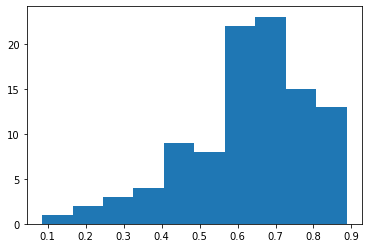

In [17]:
#this gives us a stability prediction for each sample (in this case just of the 100 subsamples)
plt.hist(stability_prediction)
plt.show()

In [18]:
#we can choose to use the predictions to get samples of a given stability
stable_physical_subsample = physical_samples_subsample[stability_prediction>.5,:]

#we can check the results again against the truths
for i,p in enumerate(params):
    t = truths[i]
    ssamp = stable_physical_subsample[:,i]
    f = np.median(ssamp)
    c = np.std(ssamp)
    if f+c>=t and f-c<=t:
        outcome = 'consistent with true value (' + str(t) +')'
    else:
        outcome = 'NOT consistent with true value (' + str(t) +')'
    print(p+':',f,'+/-',c,outcome)

#all of these samples could also be plotted using the corner package
#this could provide a better idea of how each step is changing the sample

m1: 9.493219663413365e-05 +/- 8.900966609647968e-05 consistent with true value (1e-05)
P1: 6.278213227553812 +/- 0.0004153815746922936 NOT consistent with true value (6.28)
l1: -0.07473481629256581 +/- 0.00032471678861588783 NOT consistent with true value (0)
esin1: -0.09402831980399294 +/- 0.0012388249548054228 NOT consistent with true value (0.024740395925452296)
ecos1: 0.01540546681605356 +/- 0.0005759118423047318 NOT consistent with true value (0.09689124217106448)
m2: 0.00012861716002317037 +/- 7.9400266512632e-05 NOT consistent with true value (1e-05)
P2: 14.628470200846243 +/- 0.0019887704887017834 consistent with true value (14.63)
l2: 1.5297711018819387 +/- 0.0024042934847436958 NOT consistent with true value (1.5707963267948966)
esin2: -0.07946304525098266 +/- 0.0022474271489751033 NOT consistent with true value (-0.05)
ecos2: -0.0215596820523949 +/- 0.001929515633644978 NOT consistent with true value (3.061616997868383e-18)
m3: 0.00011562742188348947 +/- 8.750723935731453e-0

In [19]:
#samples_Zstable
#this is only for TWO PLANET systems
#based on the analytical stability criterion in Hadden & Lithwick 2018
#returns Z and Zcritical for each sample (stable when Z<Zcrit)

#because our system is a 3-planet system, I won't illustrate this here
#but the output can be used in the same way as the samples_SPOCK output except it's a binary stable/unstable

*stable_physical_LS_fit*

This function combines all the previous functions into one. It uses the fitting function to get a fit and covariance matrix, which it then uses the physical samples function to turn into a physical sample of a given size (set by Nsamp, default is 10^5). From those samples, it uses either the SPOCK function or Z critera function (depending on if N=2 or N>2) to get the stable samples, using some threshold for what to consider stable from SPOCK (set by stability_threshold, default is 0.05).

When run, the function will print the calculated fit as well as saving it in an npz format (the uid argument (string) is used to save unique filenames). If save_steps is turned on (default), will also save npz files after each step.

This function was written to use posteriors from observational data. Planetary periods are input as a 1D length-N array. Planetary radii are input as a 2D array of size (length-posterior,N). These posteriors are used with the `mr_forecaster` package (Chen & Kipping 2017) to predict initial masses. Planetary impact parameter posteriors are input as well, also in 2D array of size (length-posterior,N). The impact parameters are used to calculate inclinations.

The actual return of the function is the set of physical, stable samples.

I won't run this here because I don't have a good sample dataset handy and it takes quite a while to run.

In [20]:
#chisq_TTV
#this function returns the chi squared and degrees of freedom for a given fitted parameter set
#taking into accounts the errors on the data (TTVs_std) and from the model (from fitting the linear ephemeris)
#I won't use this one here since I don't have the TTVs data set up that way

In [21]:
#chisq_tt
#this function returns the chi squared and degrees of freedom for a given fitted parameter set
#taking into accounts only the errors on the data (tts_std)
#directly compares transit times and not TTVs

#this does take masses/orbits as an input, but it doesn't matter too much
#only the masses[0] for Mstar and the inc/Om from the orbits are used, the rest use the parameter set given
chisq,dof = TTV_fitting.chisq_tt(fit,[tns,tts,pflags,tts_std],
                                  guess_masses,guess_orbits,t0,tmax,tref)

print('fit from just least squares')
print('chi squared:',chisq)
print('reduced chi squared:',chisq/dof)

chisq,dof = TTV_fitting.chisq_tt(fitphys,[tns,tts,pflags,tts_std],
                                  guess_masses,guess_orbits,t0,tmax,tref)

print()
print('fit from physical samples based on least squares covariance')
print('chi squared:',chisq)
print('reduced chi squared:',chisq/dof)

chisq,dof = TTV_fitting.chisq_tt(np.median(stable_physical_subsample,axis=0),[tns,tts,pflags,tts_std],
                                  guess_masses,guess_orbits,t0,tmax,tref)

print()
print('fit from stable subset of physical samples')
print('chi squared:',chisq)
print('reduced chi squared:',chisq/dof)

fit from just least squares
chi squared: 0.05919209096547533
reduced chi squared: 0.00022252665776494485

fit from physical samples based on least squares covariance
chi squared: 0.06226464536612657
reduced chi squared: 0.00023407761415837055

fit from stable subset of physical samples
chi squared: 0.06599628632152894
reduced chi squared: 0.0002481063395546201


In [22]:
#output_tts
#this function is mostly just to be used by the chisq_tt function
#given masses, orbits, and min/max and reference time, returns an array of transit times
#uses a provided set of data ([tns,tts,pflags,tts_std]) to match the returned transit times to the same planet/transit number